In [1]:
from datetime import date
from glob import glob
import os, sys
from os.path import join, dirname
import pickle
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import nilearn.image, nilearn.masking
from nilearn import plotting as nplt

In [2]:
# To make plots using Matplotlib, you must first enable IPython's matplotlib mode.
# To do this, run the %matplotlib magic command to enable plotting in the current Notebook.
# This magic takes an optional argument that specifies which Matplotlib backend should be used. 
# Most of the time, in the Notebook, you will want to use the inline backend,
# which will embed plots inside the Notebook:
%matplotlib inline

In [3]:
sigma_1 = 0.682689492137
sigma_2 = 0.954499736104
sigma_3 = 0.997300203937

In [4]:
fMRI_dir = '/Volumes/T7SSD1/GD/fMRI_data'
preproc_dir = fMRI_dir + '/preproc_data'
stat_dir = fMRI_dir + '/stats'
mask_dir = fMRI_dir + '/masks'

mask_full_dir = mask_dir + '/full'                # tlrc
mask_caudate_dir = mask_dir + '/GA_caudate_roi'   # orig
mask_split_dir = mask_dir + '/split_roi'          # orig
mask_caudate_fin_dir = mask_caudate_dir + '/slicer_2/tlrc_resam_fullmask' # MNI

In [5]:
temp = glob(join(preproc_dir,'GD*'))
subj_list = [a[-4:] for a in temp]
print(subj_list,'\n',len(subj_list))
# outliers : GD29, GD31
# No data : GD19
subj_list = ['GD01', 'GD02', 'GD07', 'GD11', 'GD15',
             'GD20', 'GD23', 'GD26', 'GD30', 'GD32',
             'GD33', 'GD44']

['GD01', 'GD02', 'GD07', 'GD11', 'GD15', 'GD20', 'GD23', 'GD26', 'GD29', 'GD30', 'GD31', 'GD32', 'GD33', 'GD44'] 
 14


In [6]:
def fast_masking(img, roi):
    img_data = img.get_fdata()
    roi_mask = roi.get_fdata().astype(bool)

    if img_data.shape[:3] != roi_mask.shape:
        if roi_mask.shape[-1] == 1:
            volume = roi_mask.shape[:3]
            roi_mask = roi_mask.reshape(volume)
        else:
            raise ValueError('different shape while masking! img=%s and roi=%s' % (img_data.shape, roi_mask.shape))

    return img_data[roi_mask,:]

In [7]:
def write_data_nifti(data, mask_img, fname):
    if len(mask_img.shape)!=3:
        raise ValueError('mask image should be in 3D format')
    mask_img_asarray = mask_img.get_fdata()
    template = np.zeros_like(mask_img_asarray)
    template[np.where(mask_img_asarray==1)]=data
    img_write = nib.Nifti1Image(template, mask_img.affine)
    img_write.to_filename(fname)

In [8]:
def accuracy(train_X, train_y, test_X, test_y):
    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
    lda.fit(train_X, train_y)
    
    return np.mean(lda.predict(test_X) == test_y)

def cross_validation(datasets, target):
    train_y = target + target
    test_y = target
    
    result = []
    
    for i in range(len(datasets)):
        train_X = np.concatenate([a for j, a in enumerate(datasets) if j != i])
        test_X = datasets[i]
        
        result.append(accuracy(train_X, train_y, test_X, test_y))
        
    return np.mean(result)

## Masks

(225, 321, 321)
(array([23159596,     7246,     1318,    16065]), array([0., 1., 2., 3., 4.]))


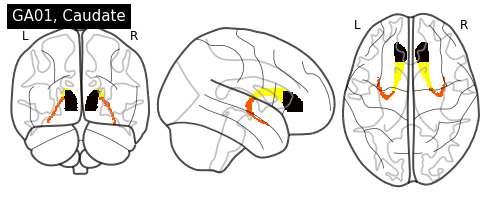

In [9]:
## ROIs of individual subjects (0.700 x 0.700 x 0.700)
subj = 'GA01'
path_roi = join(mask_caudate_dir,'%s.nii.gz'%subj)
roi = nilearn.image.load_img(path_roi)
print(roi.shape)
print(np.histogram(roi.get_fdata(), bins=4))
nplt.plot_glass_brain(roi, title='%s, Caudate'%subj)

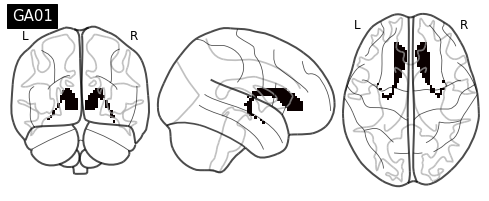

In [10]:
os.chdir(mask_caudate_dir)

subj = 'GA01'
path_epi = join(stat_dir,'Reg1_GLM_test','group','statsRWDtime.GD%s.run1to3.SPMG2.nii.gz'%subj[2:])
os.system('3dresample -master %s -prefix %s_resam.nii.gz -input %s.nii.gz'%(path_epi,subj,subj))
os.system("3dcalc -a %s_resam.nii.gz -expr 'ispositive(a)' -prefix %s_resam_all1.nii.gz"%(subj,subj))

path_roi = join(mask_caudate_dir,'%s_resam_all1.nii.gz'%subj)
roi = nilearn.image.load_img(path_roi)
nplt.plot_glass_brain(roi, title='%s'%subj)

(72, 85, 72)
(array([320271,      0,      0, 120369]), array([0.  , 0.25, 0.5 , 0.75, 1.  ]))


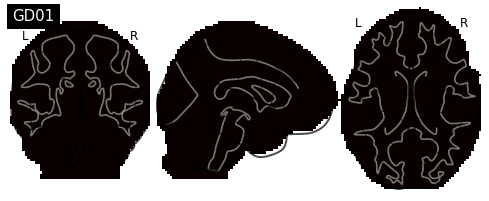

In [11]:
## Full masks of individual subjects (2.682 x 2.682 x 2.682)
subj = 'GD01'
path_data = join(mask_full_dir,'full_mask.%s.nii.gz'%subj)
roi = nilearn.image.load_img(path_data)
print(roi.shape)
print(np.histogram(roi.get_fdata(), bins=4))
nplt.plot_glass_brain(roi, title='%s'%subj)

In [12]:
list_split_mask = glob(join(mask_split_dir,'*.nii.gz'))
list_split_mask

['/Volumes/T7SSD1/GD/fMRI_data/masks/split_roi/RL_01_Pu_resam_L_ant.nii.gz',
 '/Volumes/T7SSD1/GD/fMRI_data/masks/split_roi/RL_01_Pu_resam_L_ant_1gap.nii.gz',
 '/Volumes/T7SSD1/GD/fMRI_data/masks/split_roi/RL_01_Pu_resam_L_pos.nii.gz',
 '/Volumes/T7SSD1/GD/fMRI_data/masks/split_roi/RL_01_Pu_resam_R_ant.nii.gz',
 '/Volumes/T7SSD1/GD/fMRI_data/masks/split_roi/RL_01_Pu_resam_R_ant_1gap.nii.gz',
 '/Volumes/T7SSD1/GD/fMRI_data/masks/split_roi/RL_01_Pu_resam_R_pos.nii.gz',
 '/Volumes/T7SSD1/GD/fMRI_data/masks/split_roi/RL_01_Pu_resam_ant.nii.gz',
 '/Volumes/T7SSD1/GD/fMRI_data/masks/split_roi/RL_01_Pu_resam_ant_1gap.nii.gz',
 '/Volumes/T7SSD1/GD/fMRI_data/masks/split_roi/RL_01_Pu_resam_pos.nii.gz',
 '/Volumes/T7SSD1/GD/fMRI_data/masks/split_roi/RL_02_Ca_resam_L.nii.gz',
 '/Volumes/T7SSD1/GD/fMRI_data/masks/split_roi/RL_02_Ca_resam_R.nii.gz',
 '/Volumes/T7SSD1/GD/fMRI_data/masks/split_roi/RL_02_Ca_resam_body.nii.gz',
 '/Volumes/T7SSD1/GD/fMRI_data/masks/split_roi/RL_02_Ca_resam_body_L.nii.gz'

(72, 85, 72)
(array([439978,      0,      0,    662]), array([0.  , 0.25, 0.5 , 0.75, 1.  ]))


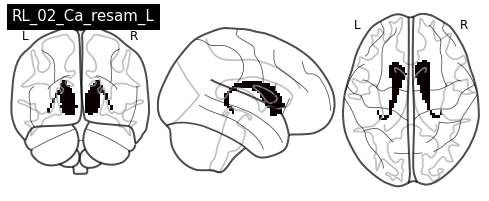

In [13]:
## original roi (2.683 x 2.683 x 2.683)
name_roi = 'RL_02_Ca_resam_R'
path_roi = join(mask_split_dir,'%s.nii.gz'%name_roi)
roiR = nilearn.image.load_img(path_roi)

name_roi = 'RL_02_Ca_resam_L'
path_roi = join(mask_split_dir,'%s.nii.gz'%name_roi)
roiL = nilearn.image.load_img(path_roi)

roi = nilearn.image.math_img("img1+img2", img1=roiR, img2=roiL)

print(roi.shape)
print(np.histogram(roi.get_fdata(), bins=4))
nplt.plot_glass_brain(roi, title=name_roi)

# Fig.4

In [14]:
print(subj_list,'\n',len(subj_list))
subj = 'GD01'

['GD01', 'GD02', 'GD07', 'GD11', 'GD15', 'GD20', 'GD23', 'GD26', 'GD30', 'GD32', 'GD33', 'GD44'] 
 12


(72, 85, 72)
(array([440063,      0,      0,    577]), array([0.  , 0.25, 0.5 , 0.75, 1.  ]))


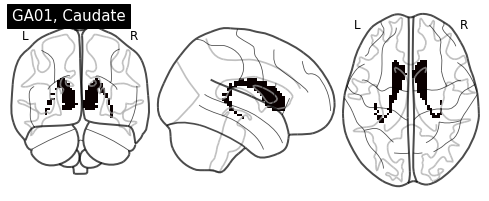

In [15]:
## Caudate manual ROIs (2.683 x 2.683 x 2.683)
temp = subj[0] + 'A' + subj[2:]
path_roi = join(mask_caudate_fin_dir,'%s_1_caudate_head_resam.nii'%temp)
roi_head = nilearn.image.load_img(path_roi)
path_roi = join(mask_caudate_fin_dir,'%s_2_caudate_body_resam.nii'%temp)
roi_body = nilearn.image.load_img(path_roi)
path_roi = join(mask_caudate_fin_dir,'%s_3_caudate_tail_resam.nii'%temp)
roi_tail = nilearn.image.load_img(path_roi)
roi = nilearn.image.math_img("np.where(img1+img2+img3>0, 1, 0)", img1=roi_head, img2=roi_body, img3=roi_tail)
print(roi.shape)
print(np.histogram(roi.get_fdata(), bins=4))
nplt.plot_glass_brain(roi, title='%s, Caudate'%temp)

## Run 1 to 3 (whole brain)

(72, 85, 72)
(array([     8,     11,     34,    161,    532,   2038,  23885, 413606,
          343,     22]), array([-19.41061211, -16.77826757, -14.14592304, -11.51357851,
        -8.88123398,  -6.24888945,  -3.61654491,  -0.98420038,
         1.64814415,   4.28048868,   6.91283321]))


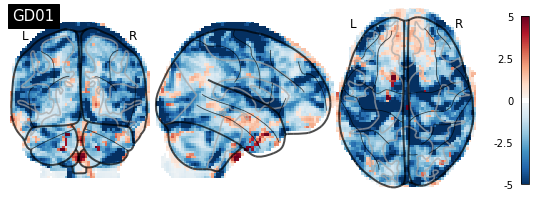

In [16]:
## epi image (2.683 x 2.683 x 2.683)
path_epi = join(stat_dir,'Reg1_GLM_test','group','statsRWDtime.%s.run1to3.SPMG2.nii.gz'%subj)
epi = nilearn.image.load_img(path_epi)
print(epi.shape)
print(np.histogram(epi.get_fdata()))
nplt.plot_glass_brain(epi, title='%s'%subj, vmax=5.0, plot_abs=False, cmap='RdBu_r', colorbar=True)

(72, 85, 72)
(array([     1,      3,      5,      9,     20,     40,     88,    261,
       440197,     16]), array([-2.58137512, -2.26903478, -1.95669444, -1.64435409, -1.33201375,
       -1.01967341, -0.70733306, -0.39499272, -0.08265238,  0.22968796,
        0.54202831]))


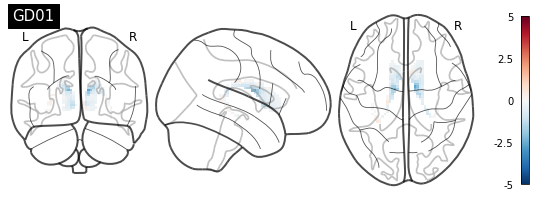

In [17]:
roi = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
print(roi.shape)
print(np.histogram(roi.get_fdata()))
nplt.plot_glass_brain(roi, title='%s'%subj, vmax=5.0, plot_abs=False, cmap='RdBu_r', colorbar=True)

## Run 4 to 6 (whole brain)

(72, 85, 72)
(array([     2,      9,     26,     99,    529,   4194, 428263,   7349,
          153,     16]), array([-14.57234383, -12.45436764, -10.33639145,  -8.21841526,
        -6.10043907,  -3.98246288,  -1.86448669,   0.25348949,
         2.37146568,   4.48944187,   6.60741806]))


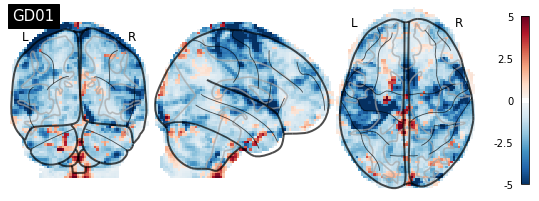

In [18]:
## epi image (2.683 x 2.683 x 2.683)
path_epi = join(stat_dir,'Reg1_GLM_test','group','statsRWDtime.%s.run4to6.SPMG2.nii.gz'%subj)
epi = nilearn.image.load_img(path_epi)
print(epi.shape)
print(np.histogram(epi.get_fdata()))
nplt.plot_glass_brain(epi, title='%s'%subj, vmax=5.0, plot_abs=False, cmap='RdBu_r', colorbar=True)

(72, 85, 72)
(array([440509,     83,     24,      6,      6,      6,      4,      0,
            0,      2]), array([-0.24062299,  0.21670963,  0.67404225,  1.13137486,  1.58870748,
        2.0460401 ,  2.50337272,  2.96070534,  3.41803796,  3.87537058,
        4.3327032 ]))


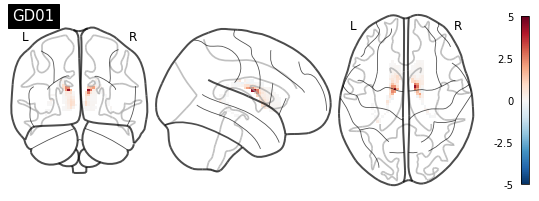

In [19]:
roi = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
print(roi.shape)
print(np.histogram(roi.get_fdata()))
nplt.plot_glass_brain(roi, title='%s'%subj, vmax=5.0, plot_abs=False, cmap='RdBu_r', colorbar=True)

## Run 1 to 3 (ROI)

(72, 85, 72)
(array([     6,     30, 440132,     99,    123,     96,     77,     59,
           13,      5]), array([-0.45143288, -0.2852764 , -0.11911991,  0.04703658,  0.21319307,
        0.37934956,  0.54550605,  0.71166254,  0.87781903,  1.04397551,
        1.210132  ]))


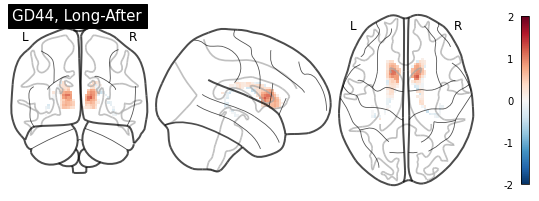

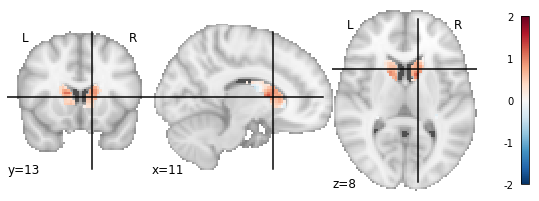

In [30]:
## epi image (2.683 x 2.683 x 2.683)
path_epi = join(stat_dir,'Reg2_GLM_caudate','group','statsRWDtime.%s.run1to3.SPMG2.nii.gz'%subj)
epi = nilearn.image.load_img(path_epi)
print(epi.shape)
print(np.histogram(epi.get_fdata()))
nplt.plot_glass_brain(epi, title='%s, Long-After'%subj, vmax=2.0, plot_abs=False, cmap='RdBu_r', colorbar=True)
nplt.plot_stat_map(epi, vmax=2.0, cmap='RdBu_r')

## Run 4 to 6 (ROI)

(72, 85, 72)
(array([     2,      6,     13, 440096,     95,    136,    119,    103,
           59,     11]), array([-0.3370887 , -0.23130654, -0.12552438, -0.01974221,  0.08603995,
        0.19182211,  0.29760427,  0.40338644,  0.5091686 ,  0.61495076,
        0.72073293]))


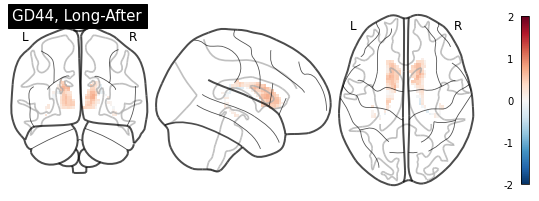

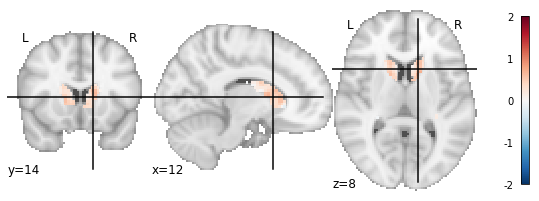

In [29]:
## epi image (2.683 x 2.683 x 2.683)
path_epi = join(stat_dir,'Reg2_GLM_caudate','group','statsRWDtime.%s.run4to6.SPMG2.nii.gz'%subj)
epi = nilearn.image.load_img(path_epi)
print(epi.shape)
print(np.histogram(epi.get_fdata()))
nplt.plot_glass_brain(epi, title='%s, Long-After'%subj, vmax=2.0, plot_abs=False, cmap='RdBu_r', colorbar=True)
nplt.plot_stat_map(epi, vmax=2.0, cmap='RdBu_r')

## Fig.4 group

In [22]:
df = pd.DataFrame(columns=['subj','mean','roi','mapping'])
for subj in subj_list:
    ## individual roi mask
    temp = subj[0] + 'A' + subj[2:]
    path_roi = join(mask_caudate_fin_dir,'%s_1_caudate_head_resam.nii'%temp)
    roi_head = nilearn.image.load_img(path_roi)
    path_roi = join(mask_caudate_fin_dir,'%s_2_caudate_body_resam.nii'%temp)
    roi_body = nilearn.image.load_img(path_roi)
    path_roi = join(mask_caudate_fin_dir,'%s_3_caudate_tail_resam.nii'%temp)
    roi_tail = nilearn.image.load_img(path_roi)
    
    ## epi (Run 1 to 3)
    path_epi = join(stat_dir,'Reg2_GLM_caudate','group','statsRWDtime.%s.run1to3.SPMG2.nii.gz'%subj)
    epi = nilearn.image.load_img(path_epi)
    ## caudate head
    roi = roi_head
    size_roi = np.sum(roi_head.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    df = df.append({'subj':subj,'mean':mean,'roi':'head','mapping':'trained'}, ignore_index=True)
    ## caudate body
    roi = roi_body
    size_roi = np.sum(roi_body.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    df = df.append({'subj':subj,'mean':mean,'roi':'body','mapping':'trained'}, ignore_index=True)
    ## caudate tail
    roi = roi_tail
    size_roi = np.sum(roi_tail.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    df = df.append({'subj':subj,'mean':mean,'roi':'tail','mapping':'trained'}, ignore_index=True)
    
    ## epi (Run 4 to 6)
    path_epi = join(stat_dir,'Reg2_GLM_caudate','group','statsRWDtime.%s.run4to6.SPMG2.nii.gz'%subj)
    epi = nilearn.image.load_img(path_epi)
    ## caudate head
    roi = roi_head
    size_roi = np.sum(roi_head.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    df = df.append({'subj':subj,'mean':mean,'roi':'head','mapping':'untrained'}, ignore_index=True)
    ## caudate body
    roi = roi_body
    size_roi = np.sum(roi_body.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    df = df.append({'subj':subj,'mean':mean,'roi':'body','mapping':'untrained'}, ignore_index=True)
    ## caudate tail
    roi = roi_tail
    size_roi = np.sum(roi_tail.get_fdata())
    temp = nilearn.image.math_img("img1*img2", img1=epi, img2=roi)
    mean = np.sum(temp.get_fdata())/size_roi
    df = df.append({'subj':subj,'mean':mean,'roi':'tail','mapping':'untrained'}, ignore_index=True)

df

,subj,mean,roi,mapping
0,GD01,-0.222436,head,trained
1,GD01,-0.593712,body,trained
2,GD01,-0.115031,tail,trained
3,GD01,-0.276899,head,untrained
4,GD01,-0.341795,body,untrained
...,...,...,...,...
67,GD44,0.114132,body,trained
68,GD44,-0.106895,tail,trained
69,GD44,0.351881,head,untrained
70,GD44,0.228941,body,untrained


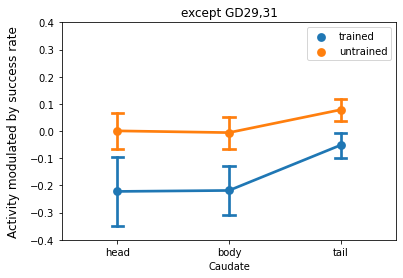

In [26]:
ax = sns.pointplot(x='roi', y='mean', data=df,
                   ci=sigma_1*100,      # ci=standard error
                   hue='mapping',
                   capsize=.1,
                   markers='o')
ax.set_ylim(-.4,.4)
ax.set_ylabel('Activity modulated by success rate', fontsize=12, labelpad=10)
ax.set_xlabel('Caudate')
ax.set_title('except GD29,31')
ax.legend(loc='best')
# plt.savefig('mean_cadate.png', dpi=300)